In [20]:
__author__ = '@Tssp'
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from codvidutils.Autoencoder_Uncertainty_Transformation_main import Transformation_main
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
from codvidutils.imageproc import map_categorical
from PIL import Image
from keras.models import load_model

In [2]:
Y_test = []
preds = []
for it in range(5):
    model = 'hdf_files/Uncertainty_AE_Covid_{}.hdf5'.format(it+1)
    outputs = Transformation_main('data/train_split_v4.csv', 'data/test_split_v5.csv', model)
    Y_test = outputs['Y_test']
    preds += [np.loadtxt('log/preds_XGBr_Uncertainty_{}.txt'.format(it+1), delimiter=',')]
    del outputs

You are going to read from: data/train_split_v4.csv and data/test_split_v5.csv
Total number of images: 1524
shape X: 13600 1524,  disease_ID (Y): 13600 1524
Count of classes:  Counter({0: 7966, 2: 5447, 1: 187})
New diseaseID shape:  (9097,)
New X shape:  (9097, 120000)
New Count of classes:  Counter({0: 4500, 2: 4500, 1: 97})
Undersample shapes:
diseaseID_train.shape: (9097,)
X_train.shape: (9097, 120000)
X_train.shape: (9097, 200, 200, 3)
X_test.shape: (1524, 200, 200, 3)
Normal train:  (4500,)
Pneumonia train:  (4500,)
COVID train:  (97,)
*******************************************************
Normal test:  (880,)
Pneumonia test:  (586,)
COVID test:  (58,)
(2425, 180, 180, 3)
(2425,)
X_train.shape:  (11522, 180, 180, 3)
diseaseID_train.shape:  (11522,)
X_test_news.shape:  (1450, 180, 180, 3)
diseaseID_test_news.shape:  (1450,)
X_test.shape:  (2974, 180, 180, 3)
diseaseID_test.shape:  (2974,)
encoder_test.shape (2974, 23, 23, 70)
encoder_train.shape (11522, 23, 23, 70)
You are going 

In [3]:
predictive_mean = np.mean(preds, axis=0)
predictive_variance = np.var(preds, axis=0)
print("Mean: {}\nStd: {}".format(predictive_mean, predictive_variance))

Mean: [0.24281604 0.5311683  0.44169112 ... 0.55988932 0.60686467 0.31685401]
Std: [0.00082755 0.0072302  0.0052276  ... 0.00376151 0.00064119 0.00093641]


## Following Gal's approach:
## $$\tau = \frac{1-p}{2Nl_2}$$
## where $p$ is the probability of the dropout layers, $N$ the number of predictions and $l_2$ the regularization parameter

In [4]:
p = 0.10
N = len(preds)
l2 = 0.005
tau = (1 - p)/(2*N*l2)
E_s = 1/tau
E_t = np.sqrt(predictive_variance + E_s)
print("tau: {}\nError: {}\nTotal Error: {}".format(tau, E_s, E_t))

tau: 18.0
Error: 0.05555555555555555
Total Error: [0.23745127 0.25057087 0.24654241 ... 0.24355095 0.23705854 0.23768039]


In [5]:
predictive_mean_up = predictive_mean + E_t
predictive_mean_down = predictive_mean - E_t

# Confusion matrices

In [12]:
cm_up = confusion_matrix(Y_test, predictive_mean_up.round())
cm = confusion_matrix(Y_test, predictive_mean.round())
print('{} of {} no COVID-19 ({:2.4}%)'.format(cm[0,0], cm[0,0] + cm[0,1], 100*cm[0,0]/(cm[0,0]+cm[0,1])))
print('{} of {} COVID-19 ({:2.3}%)'.format(cm[1,1], cm[1,1] + cm[1,0], 100*cm[1,1]/(cm[1,1]+cm[1,0])))
print("Means + E_t:\n{}".format(cm))
cm_down = confusion_matrix(Y_test, predictive_mean_down.round())
# Distance taking into account the error interval
dist_up = np.absolute(cm_up - cm)
dist_down = np.absolute(cm - cm_down)
print("Upper distance:\n{}".format(dist_up))
print("Lower distance:\n{}".format(dist_down))

1450 of 1466 no COVID-19 (98.91%)
391 of 1508 COVID-19 (25.9%)
Means + E_t:
[[1450   16]
 [1117  391]]
Upper distance:
[[419 419]
 [893 893]]
Lower distance:
[[ 16  16]
 [391 391]]


# Histograms

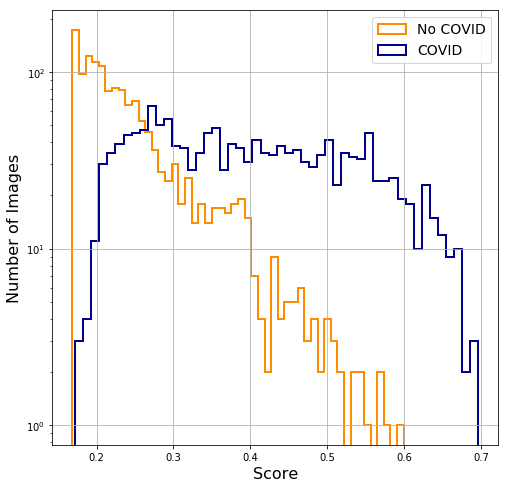

In [51]:
nocovid = predictive_mean[np.where(Y_test == 0)]
covid = predictive_mean[np.where(Y_test == 1)]
fig, ax = plt.subplots(figsize=(8,8))
ax.hist(nocovid, 50, histtype='step', lw=2, color='darkorange', label='No COVID')
ax.hist(covid, 50, histtype='step', lw=2, color='darkblue', label='COVID')
plt.grid()
ax.set_ylabel('Number of Images', fontsize=16)
ax.set_xlabel('Score', fontsize=16)
plt.legend( loc='upper right', fontsize=14)
plt.yscale("log")
fig.savefig('Figures/histogram_Uncertainty_XGBr.eps', dpi=200)

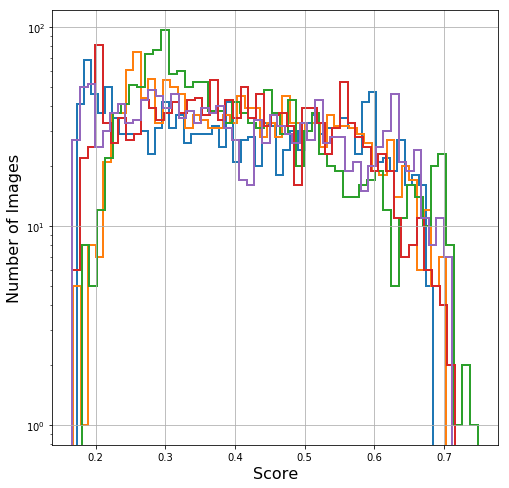

In [58]:
fig2, ax2 = plt.subplots(figsize=(8,8))
for pred in preds:
    nocovid = pred[np.where(Y_test == 0)]
    covid = pred[np.where(Y_test == 1)]
    #ax2.hist(nocovid, 50, histtype='step', lw=2, label='No COVID')
    ax2.hist(covid, 50, histtype='step', lw=2, label='COVID')
plt.grid()
ax2.set_ylabel('Number of Images', fontsize=16)
ax2.set_xlabel('Score', fontsize=16)
#plt.legend( loc='upper right', fontsize=14)
plt.yscale("log")
fig2.savefig('Figures/histograms_Covid_Uncertainty_XGBr.eps', dpi=200)